# gensim

[Gensim](https://radimrehurek.com/gensim/) is a topic modeling API. However, gensim also has the ability to create word and document embeddings. Below is a dataset of book titles dealing with two "topics", one for "data science" and the other for "finance". We will use this dataset to see how gensim can be used to learn and recover topics.

In [1]:
import pandas as pd
import numpy as np
import random

np.random.seed(37)
random.seed(37)

df = pd.DataFrame({
    'text': [
        'Data Science from Scratch: First Principles with Python',
        'Data Science for Business: What You Need to Know about Data Mining and Data-Analytic Thinking',
        'Practical Statistics for Data Scientists',
        'Build a Career in Data Science',
        'Python Data Science Handbook',
        'Storytelling with Data: A Data Visualization Guide for Business Professionals',
        'R for Data Science: Import, Tidy, Transform, Visualize, and Model Data',
        'Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control',
        'A Hands-On Introduction to Data Science',
        'Intro to Python for Computer Science and Data Science: Learning to Program with AI, Big Data and The Cloud',
        'How Finance Works: The HBR Guide to Thinking Smart About the Numbers',
        'The Intelligent Investor: The Definitive Book on Value Investing. A Book of Practical Counsel',
        'Introduction to Finance: Markets, Investments, and Financial Management',
        'Python for Finance: Mastering Data-Driven Finance',
        'The Infographic Guide to Personal Finance: A Visual Reference for Everything You Need to Know',
        'Personal Finance For Dummies',
        'Corporate Finance For Dummies',
        'Lords of Finance: The Bankers Who Broke the World',
        'Real Estate Finance & Investments',
        'Real Estate Finance and Investments Risks and Opportunities'
    ],
    'clazz': [1 for _ in range(10)] + [0 for _ in range(10)]
})

df.shape

(20, 2)

We have to tokenize, lemmatize and remove stop words from the original text.

In [2]:
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words('english') + list(string.punctuation))

is_valid = lambda t: t not in stop_words
tokenize = lambda t: word_tokenize(t.lower())
lemmatize = lambda t: lemmatizer.lemmatize(t)

df['normalized'] = df.text.apply(lambda text: [lemmatize(t) for t in tokenize(text) if is_valid(t)])
df.shape

(20, 3)

Words that appear only once are removed.

In [3]:
from itertools import chain
import nltk

dist = nltk.FreqDist(list(chain(*df.normalized)))
dist = pd.Series([v for _, v in dist.items()], dist.keys()).sort_values(ascending=False)
dist = dist[dist > 1]
valid_tokens = set(list(dist.index))

df['valid'] = df.normalized.apply(lambda tokens: [t for t in tokens if t in valid_tokens])
df.shape

(20, 4)

## Topic modeling

Now we will apply Latent Semantic Indexing `LSI` and Laten Dirchlet Allocation `LDA` for topic modeling. 

In [4]:
from gensim import corpora

dictionary = corpora.Dictionary(df.valid)
corpus = [dictionary.doc2bow(text) for text in df.valid]

In [5]:
from gensim import models

tfidf_model = models.TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]

lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)
corpus_lsi = lsi_model[corpus_tfidf]

lda_model = models.LdaModel(corpus, id2word=dictionary, iterations=50, num_topics=2)
corpus_lda = lda_model[corpus]

### Visualize document vectors

The LSI and LDA models can transform the documents into vector representation in principal component `PC` or probabilistic space, respectively. We try to visualize the documents in these spaces as a 2D visualization. 

In [6]:
import numpy as np

lsi_data = np.array([[tup[1] for tup in arr] for arr in corpus_lsi])
lda_data = np.array([[tup[1] for tup in arr] for arr in corpus_lda])

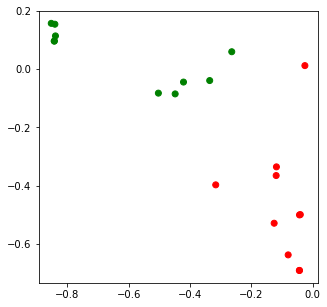

In [7]:
import matplotlib.pyplot as plt

x = lsi_data[:,0]
y = lsi_data[:,1]
c = ['r' if i == 0 else 'g' for i in df.clazz]

fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.scatter(x, y, c=c)

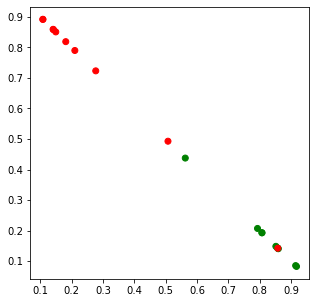

In [8]:
x = lda_data[:,0]
y = lda_data[:,1]
c = ['r' if i == 0 else 'g' for i in df.clazz]

fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.scatter(x, y, c=c)

### Print word to topic relevance

The word importances to each topic can also be retrieved.

In [9]:
lsi_model.print_topics()

[(0,
  '-0.641*"data" + -0.572*"science" + -0.412*"python" + -0.165*"learning" + -0.119*"introduction" + -0.109*"business" + -0.100*"data-driven" + -0.080*"finance" + -0.079*"guide" + -0.065*"thinking"'),
 (1,
  '-0.638*"finance" + -0.380*"investment" + -0.312*"real" + -0.312*"estate" + -0.308*"dummy" + -0.200*"personal" + -0.176*"introduction" + -0.145*"guide" + -0.117*"data-driven" + 0.117*"data"')]

In [10]:
lda_model.print_topics()

[(0,
  '0.199*"data" + 0.170*"science" + 0.079*"python" + 0.067*"finance" + 0.047*"practical" + 0.047*"data-driven" + 0.043*"book" + 0.042*"need" + 0.041*"learning" + 0.041*"know"'),
 (1,
  '0.194*"finance" + 0.117*"data" + 0.073*"investment" + 0.067*"guide" + 0.054*"dummy" + 0.053*"estate" + 0.052*"real" + 0.052*"science" + 0.044*"personal" + 0.043*"introduction"')]

### Check coherence

The two coherence measures below are `u_mass` and `c_v`. At a high level, these scores try to capture how well the words in each topic fit (co-occur) together. Better information about these scores are available at the links following. 

- [How does topic coherence score in LDA intuitively makes sense?](https://stats.stackexchange.com/questions/375062/how-does-topic-coherence-score-in-lda-intuitively-makes-sense)
- [What is the formula for c_v coherence?](https://stats.stackexchange.com/questions/406216/what-is-the-formula-for-c-v-coherence)

In [11]:
from gensim.models.coherencemodel import CoherenceModel

lsi_cm = CoherenceModel(model=lsi_model, corpus=corpus_lsi, coherence='u_mass')
lda_cm = CoherenceModel(model=lda_model, corpus=corpus_lda, coherence='u_mass')

print('lsi', lsi_cm.get_coherence())
print('lda', lda_cm.get_coherence())

lsi -2.5045662415022893
lda -4.4435852671814855


In [12]:
lsi_cm = CoherenceModel(model=lsi_model, texts=df.valid, coherence='c_v')
lda_cm = CoherenceModel(model=lda_model, texts=df.valid, coherence='c_v')

print('lsi', lsi_cm.get_coherence())
print('lda', lda_cm.get_coherence())

lsi 0.5731227064090376
lda 0.5731227064090375


### Check clustering quality

The silhouette score can evaluate the clustering quality without the truth labels, while the rand score will evaluate the clustering quality with the truth labels. For both these scores, a higher value is better.

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, rand_score

kmeans = KMeans(n_clusters=2, random_state=37).fit(lsi_data)
sil_score = silhouette_score(lsi_data, kmeans.labels_)
ran_score = rand_score(df.clazz, kmeans.labels_)

print(f'silhouette: {sil_score:.5f}, rand: {ran_score}')

silhouette: 0.58734, rand: 1.0


In [14]:
kmeans = KMeans(n_clusters=2, random_state=37).fit(lda_data)
sil_score = silhouette_score(lsi_data, kmeans.labels_)
ran_score = rand_score(df.clazz, kmeans.labels_)

print(f'silhouette: {sil_score:.5f}, rand: {ran_score}')

silhouette: 0.54072, rand: 0.8105263157894737


## word2vec

Word2vec `w2v` is an approach to vectorize words such that in the vector space, words that have similar meaning will be closer algebraically. These vectors are often called `embeddings`. The field has matured to the point where embeddings may be created for all sorts of data (not only text but also images). For example, there are also sentence, paragraph and document embeddings techniques. 

Below, we learn word embeddings for the book titles. The number of iterations `iter` is set to a very high number to get some stability. 

In [15]:
from gensim.test.utils import datapath
from gensim import utils

class BookTitleCorpus:
    def __iter__(self):
        titles = list(df.valid)
        for title in titles:
            yield title

In [16]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(**{
    'sentences': BookTitleCorpus(), 
    'size': 5, 
    'window': 1, 
    'min_count': 1, 
    'negative': 1,
    'iter': 5000,
    'compute_loss': True,
    'hs': 0,
    'sg': 1,
    'seed': 37
})

All the words that can be mapped to an embedding is access through the `wv.index2word` property.

In [17]:
w2v_model.wv.index2word

['data',
 'finance',
 'science',
 'python',
 'guide',
 'investment',
 'business',
 'need',
 'know',
 'thinking',
 'practical',
 'data-driven',
 'learning',
 'introduction',
 'book',
 'personal',
 'dummy',
 'real',
 'estate']

You may retrieve the vector for each word as follows.

In [18]:
w2v_model.wv['data']

array([ 0.593597  , -0.25675973, -0.25700533, -0.09834253,  1.0051605 ],
      dtype=float32)

In [19]:
w2v_model.wv['science']

array([-0.07897905,  0.13377394, -0.53072256, -0.42197725,  0.75260234],
      dtype=float32)

In [20]:
w2v_model.wv['finance']

array([-0.0450182 , -0.7350258 ,  0.03632208,  0.88822436, -0.7655971 ],
      dtype=float32)

You can also query for similary words.

In [21]:
print(w2v_model.wv.most_similar(positive=['data']))

[('business', 0.871295154094696), ('science', 0.6787357926368713), ('learning', 0.6179041266441345), ('thinking', 0.6133607625961304), ('need', 0.5080872178077698), ('know', 0.5036865472793579), ('guide', 0.37261903285980225), ('python', 0.3343797028064728), ('practical', 0.15768414735794067), ('book', 0.09061828255653381)]


In [22]:
print(w2v_model.wv.most_similar(positive=['science']))

[('data', 0.6787357926368713), ('practical', 0.6711301207542419), ('book', 0.5050278902053833), ('business', 0.48344868421554565), ('know', 0.335382342338562), ('guide', 0.32071053981781006), ('learning', 0.28909873962402344), ('thinking', 0.27567052841186523), ('python', 0.24710051715373993), ('need', 0.22812509536743164)]


In [23]:
print(w2v_model.wv.most_similar(positive=['finance']))

[('personal', 0.8275710344314575), ('real', 0.739374041557312), ('estate', 0.7324811220169067), ('investment', 0.6838704347610474), ('dummy', 0.5812346339225769), ('need', 0.41558361053466797), ('guide', 0.3766511082649231), ('thinking', 0.3643118143081665), ('know', 0.3500431776046753), ('introduction', 0.04492002725601196)]


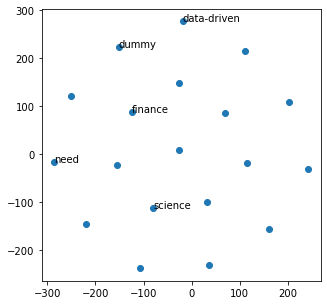

In [25]:
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model):
    num_dimensions = 2

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(w2v_model)

fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.scatter(x_vals, y_vals)

indices = list(range(len(labels)))
selected_indices = random.sample(indices, 5)
for i in selected_indices:
    ax.annotate(labels[i], (x_vals[i], y_vals[i]))

## doc2vec

Doc2vec `d2v` creates vectors over documents. Take note of the `epochs` required for training to get stability.

In [26]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

def read_corpus(tokens_only=False):
    for i, tokens in enumerate(df.valid):
        if tokens_only:
            yield tokens
        else:
            yield TaggedDocument(tokens, [i])
                
tr_corpus = list(read_corpus())
te_corpus = list(read_corpus(True))

d2v_model = Doc2Vec(vector_size=5, min_count=1, epochs=8000)
d2v_model.build_vocab(tr_corpus)
d2v_model.train(tr_corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

After the d2v model is trained, you can infer the vectors for any text.

In [27]:
vector = d2v_model.infer_vector('data science is cool'.split(' '))
print(vector)

[-1.9255836  -0.02223318  0.2743532   2.352567    0.43010306]


In [28]:
vector = d2v_model.infer_vector('science is cool'.split(' '))
print(vector)

[-1.1838392 -0.654592   1.0636024  2.6199558  0.5647269]


In [29]:
vector = d2v_model.infer_vector('finance is cool'.split(' '))
print(vector)

[2.0806925  2.0674143  1.0229923  0.81294686 0.76004183]


Below is diagnostic code to see if a document is similar to itself. The results show that most times, a document is most similar to itself. This process is not deterministic and different runs will generate different results.

In [30]:
from collections import Counter

ranks = []

for doc_id in range(len(tr_corpus)):
    inferred_vector = d2v_model.infer_vector(tr_corpus[doc_id].words)
    sims = d2v_model.docvecs.most_similar([inferred_vector], topn=len(d2v_model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    
print(Counter(ranks))

Counter({0: 18, 1: 2})


## Word mover's distance

In [31]:
import gensim.downloader as api

wm_model1 = api.load('word2vec-google-news-300')

wm_model2 = api.load('word2vec-google-news-300')
wm_model2.init_sims(replace=True)

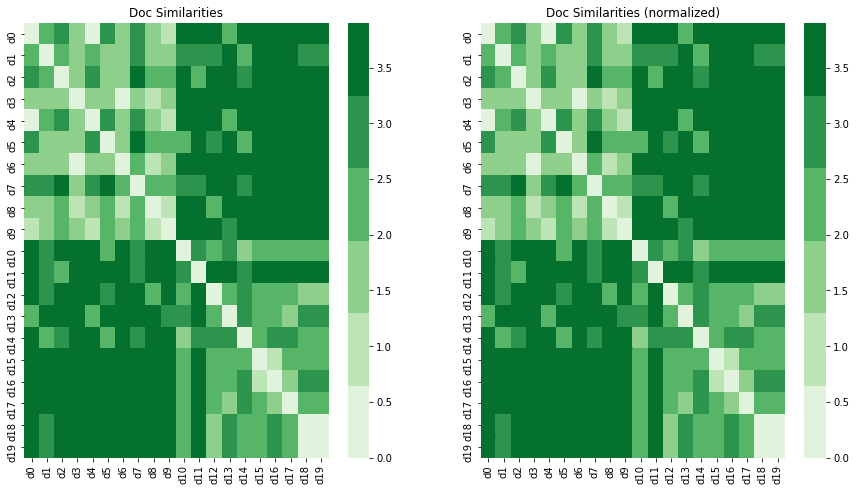

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

docs = list(df.valid)
distances1 = []
distances2 = []

for i in range(len(docs)):
    d1 = {f'd{j}': wm_model1.wmdistance(docs[i], docs[j]) for j in range(len(docs))}
    d2 = {f'd{j}': wm_model2.wmdistance(docs[i], docs[j]) for j in range(len(docs))}
    
    distances1.append(d1)
    distances2.append(d2)
    
dist_df1 = pd.DataFrame(distances1)
dist_df2 = pd.DataFrame(distances1)

dist_df1.index = [f'd{i}' for i in range(len(docs))]
dist_df2.index = [f'd{i}' for i in range(len(docs))]

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

_ = sns.heatmap(dist_df1, cmap=sns.color_palette('Greens'), ax=ax[0])
_ = sns.heatmap(dist_df2, cmap=sns.color_palette('Greens'), ax=ax[1])

_ = ax[0].set_title('Doc Similarities')
_ = ax[1].set_title('Doc Similarities (normalized)')